Bienvenue dans ce notebook Colab dédié à la détection d'objets avec YOLOv8 ! Ce notebook vous guidera à travers les étapes de préparation de l'environnement, d'entraînement d'un modèle YOLOv8, d'évaluation de ses performances, d'inférence sur de nouvelles images, et enfin d'exportation et de sauvegarde du modèle.

Cette section initialise votre environnement de travail. Elle commence par vérifier la disponibilité et la configuration d'un GPU, ce qui est crucial pour accélérer l'entraînement des modèles de deep learning. Ensuite, elle installe toutes les bibliothèques Python nécessaires, notamment `ultralytics` pour YOLOv8, `opencv-python` pour le traitement d'images, et `matplotlib` pour les visualisations.

In [2]:
# Vérifier le GPU
import torch
print("Torch:", torch.__version__)
print("CUDA dispo:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# Installer YOLOv8
!pip -q install ultralytics opencv-python matplotlib

from ultralytics import YOLO
YOLO

Torch: 2.8.0+cu126
CUDA dispo: True
GPU: Tesla T4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


ultralytics.models.yolo.model.YOLO

Dans cette partie, nous allons entraîner un modèle YOLOv8 à partir d'un poids pré-entraîné (`yolov8n.pt`). L'entraînement sera effectué sur le jeu de données `coco128.yaml`, une version plus petite du célèbre dataset COCO. Les paramètres comme le nombre d'époques, la taille d'image et le batch size sont définis pour contrôler le processus d'apprentissage. Le modèle apprendra à identifier différentes catégories d'objets présentes dans le dataset.

In [3]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

results = model.train(
    data="coco128.yaml",
    epochs=20,
    imgsz=640,
    batch=16,
    device=0 if torch.cuda.is_available() else 'cpu',
    patience=10,
    workers=2
)

print(results)

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco128.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pretrained=True

Une fois l'entraînement terminé, il est essentiel d'évaluer la performance du modèle. Cette section récupère les résultats du dernier entraînement et affiche des visualisations clés comme les courbes de précision-rappel (PR curve), la matrice de confusion, et les courbes F1. Ces graphiques nous aident à comprendre comment le modèle se comporte en termes de détection et de classification des objets.

Dernier run: runs/detect/train


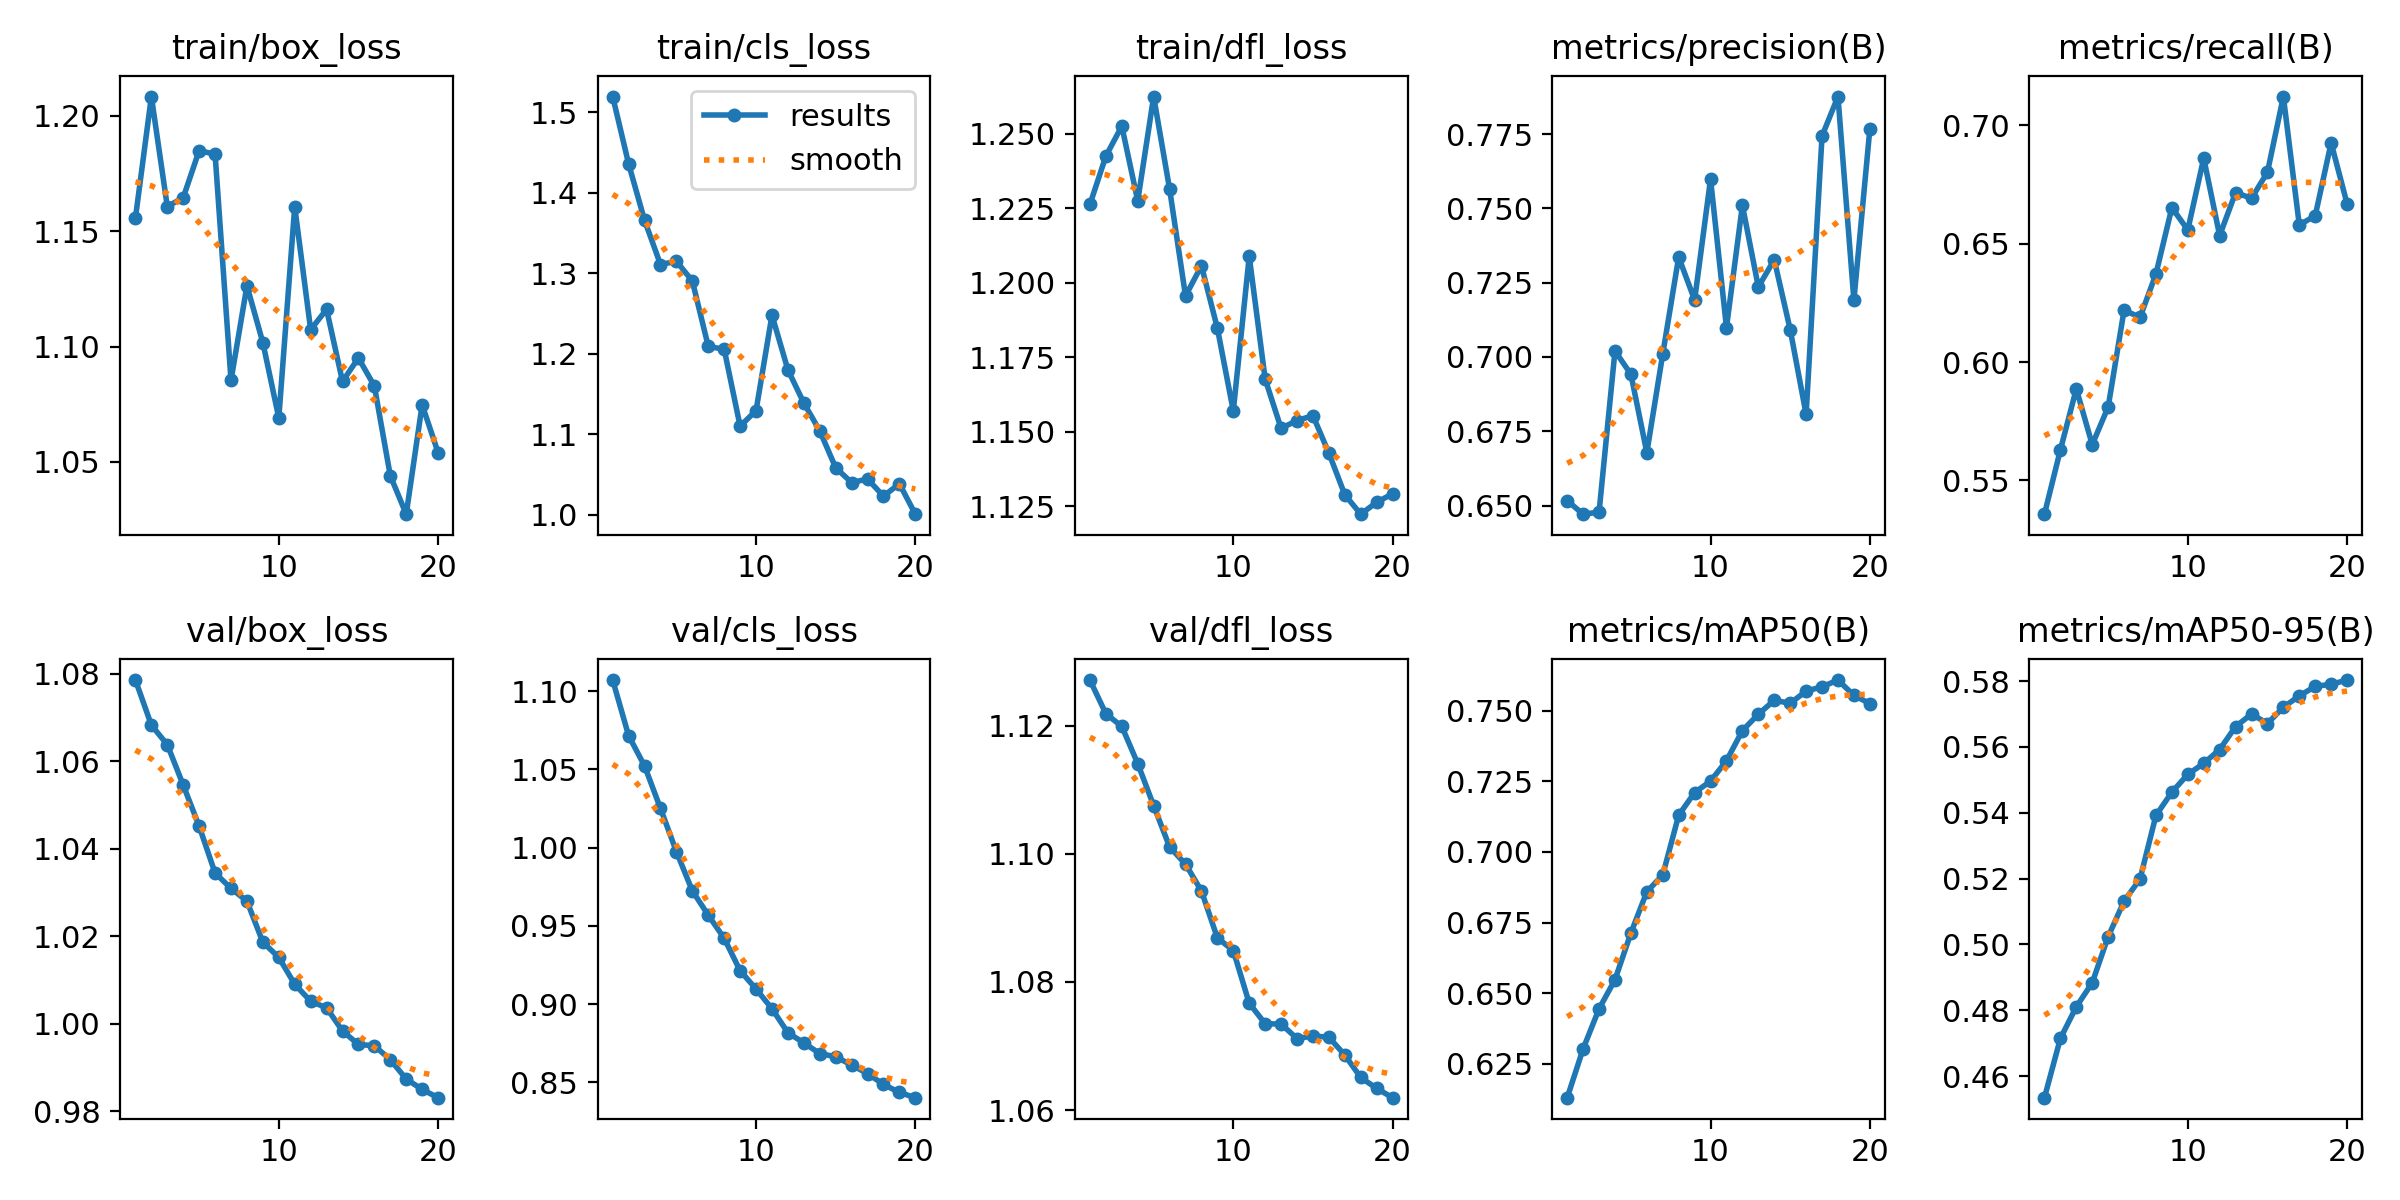

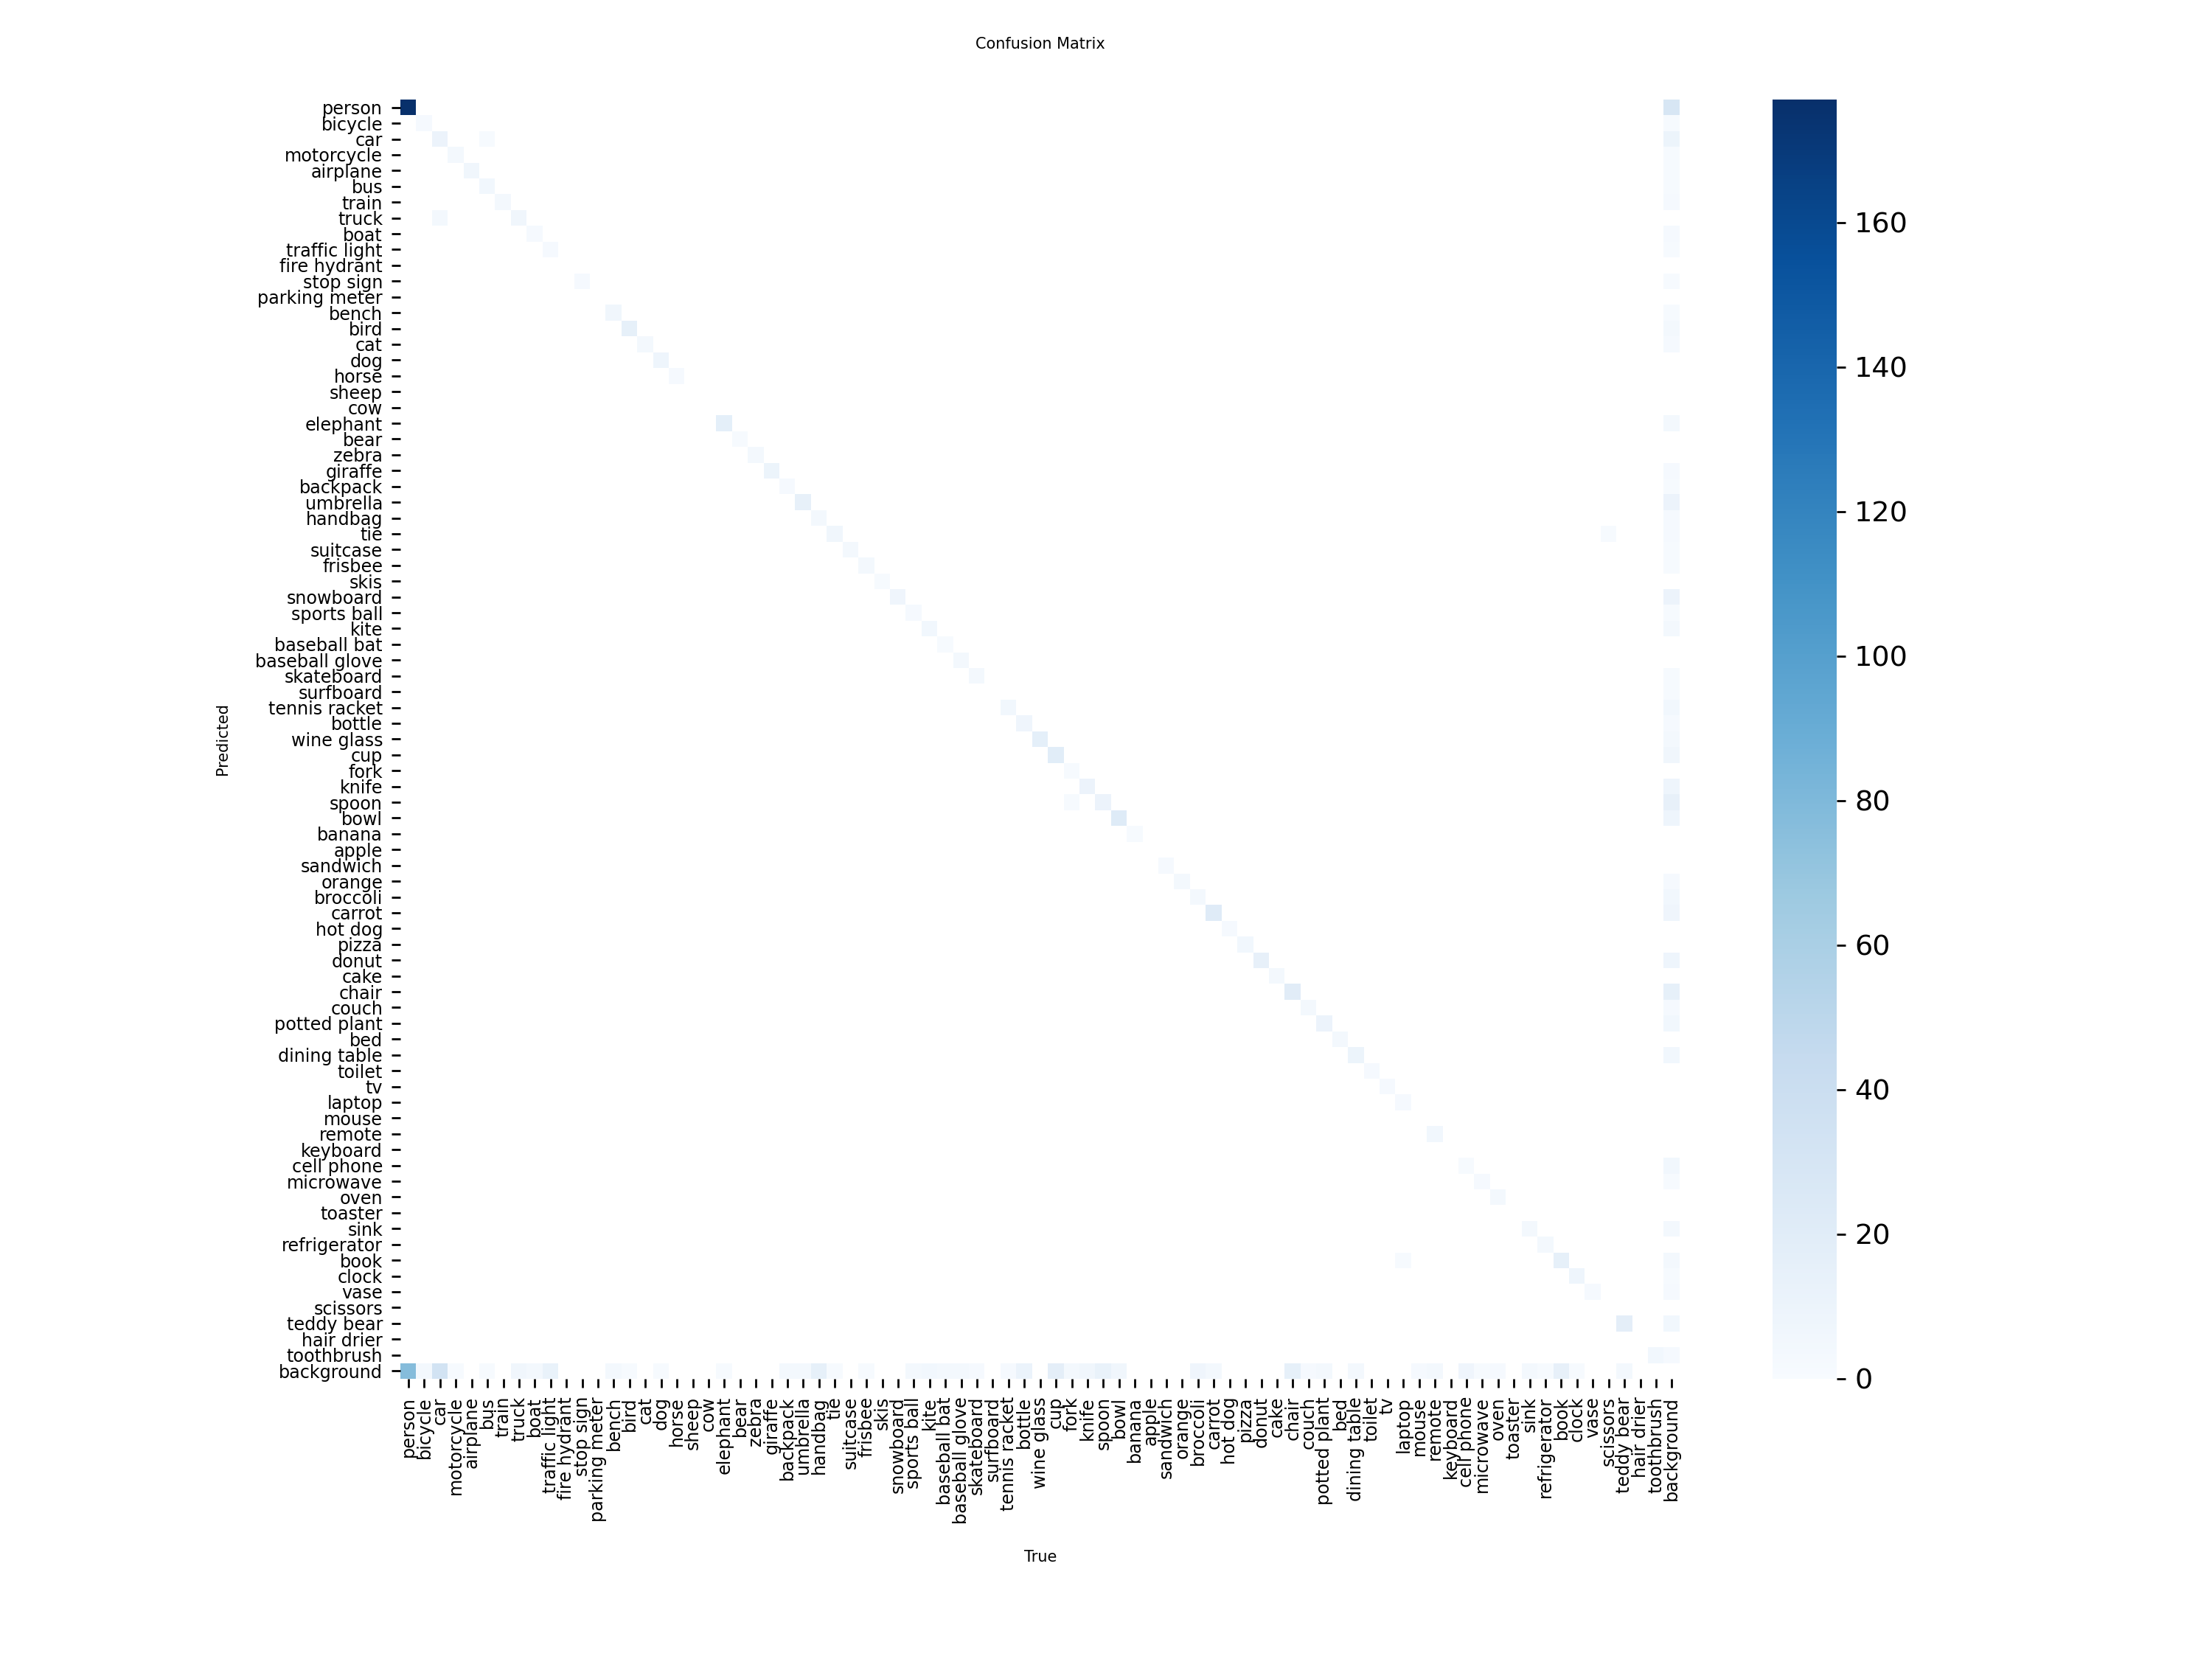

In [4]:
import IPython, os, glob

runs = sorted(glob.glob("runs/detect/train*"))
run_dir = runs[-1]
print("Dernier run:", run_dir)

for img_name in ["results.png", "confusion_matrix.png", "PR_curve.png", "F1_curve.png"]:
    path = os.path.join(run_dir, img_name)
    if os.path.exists(path):
        display(IPython.display.Image(filename=path, width=800))

Cette étape utilise la commande `yolo detect val` pour effectuer une validation formelle du modèle entraîné. Elle calcule des métriques quantitatives telles que la Mean Average Precision (mAP) à différents seuils d'IoU (Intersection over Union), fournissant une mesure objective de la précision de la détection d'objets du modèle sur le jeu de données de validation.

In [5]:
!yolo detect val model={run_dir}/weights/best.pt data=coco128.yaml imgsz=640

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1411.7±323.4 MB/s, size: 51.8 KB)
val: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 128/128 1.7Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 1.4it/s 5.9s
                   all        128        929      0.785      0.678      0.752      0.584
                person         61        254       0.91      0.636      0.793      0.585
               bicycle          3          6      0.777      0.333      0.469      0.392
                   car         12         46      0.784      0.236      0.377      0.224
            motorcycle          4          5      0.817        0.8      0.962      0.833
              airplane          5      

Ici, nous testons le modèle entraîné sur une image unique pour observer ses capacités d'inférence. Une image de bus est téléchargée et le modèle applique la détection d'objets. Les objets détectés sont visualisés directement sur l'image, permettant de juger de la performance du modèle en conditions réelles.

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

image 1/1 /content/test_images/bus.jpg: 640x480 3 persons, 1 bus, 1 stop sign, 1 skateboard, 75.7ms
Speed: 5.3ms preprocess, 75.7ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /content/runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


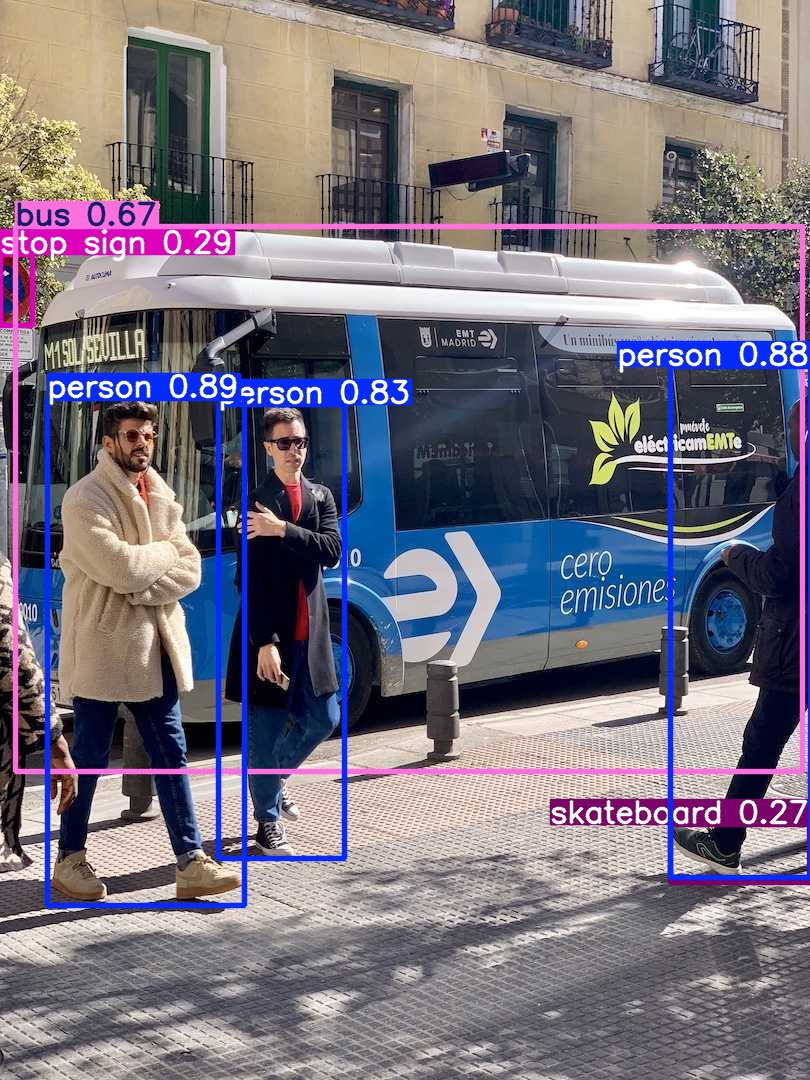

In [6]:
import urllib.request, os, glob
from IPython.display import Image, display

os.makedirs("test_images", exist_ok=True)
url = "https://raw.githubusercontent.com/ultralytics/ultralytics/main/ultralytics/assets/bus.jpg"
urllib.request.urlretrieve(url, "test_images/bus.jpg")

!yolo detect predict model={run_dir}/weights/best.pt source=test_images/ conf=0.25 save=True

pred_dirs = sorted(glob.glob("runs/detect/predict*"))
pred_dir = pred_dirs[-1]
pred_images = glob.glob(os.path.join(pred_dir, "*.jpg"))

for p in pred_images[:3]:
    display(Image(p, width=800))

Pour une interaction facile avec le modèle, nous mettons en place une mini-démonstration interactive en utilisant la bibliothèque Gradio. Cela vous permet de télécharger vos propres images et de voir instantanément les résultats de la détection d'objets par le modèle YOLOv8 directement dans le navigateur, sans avoir à écrire de code supplémentaire pour chaque test.

 Mini-demo Gradio

In [8]:
!pip -q install gradio

import gradio as gr
from ultralytics import YOLO
import tempfile
import cv2, os

model = YOLO(f"{run_dir}/weights/best.pt")

def detect_objects(img):
    tmp = tempfile.NamedTemporaryFile(suffix=".jpg", delete=False)
    cv2.imwrite(tmp.name, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    res = model.predict(source=tmp.name, conf=0.25, save=True,
project="runs/detect/gradio", name="pred", verbose=False)
    out_dir = res[0].save_dir
    outs = [p for p in os.listdir(out_dir) if p.lower().endswith((".jpg",".png",".jpeg"))]
    out_img = cv2.imread(os.path.join(out_dir, outs[0]))
    return cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)

demo = gr.Interface(fn=detect_objects, inputs=gr.Image(type="numpy"),
outputs=gr.Image(), title="YOLOv8 Demo")
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c58b9f843bd40ebb08.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Cette section est dédiée à l'exportation du modèle entraîné dans des formats optimisés pour le déploiement. Nous exportons le modèle en formats ONNX et TorchScript. Ces formats sont largement utilisés pour la production car ils permettent une inférence plus rapide et sont compatibles avec divers frameworks et environnements d'exécution, rendant le modèle plus portable et efficace.

In [9]:
!yolo export model={run_dir}/weights/best.pt format=onnx opset=12
!yolo export model={run_dir}/weights/best.pt format=torchscript

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<=1.19.1', 'onnxslim>=0.1.71', 'onnxruntime'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 363ms
Prepared 6 packages in 2.80s
Installed 6 packages in 501ms
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.19.1
 + onnxruntime==1.24.0.dev20251031003
 + onnxslim==0.1.74

requirements: AutoUpdate success ✅ 4.8s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting e

Pour sauvegarder tous les efforts d'entraînement et les résultats, cette section monte Google Drive et copie l'intégralité du dossier du dernier entraînement (contenant les poids du modèle, les logs et les visualisations) dans un répertoire désigné sur votre Drive. Cela assure que vous ne perdrez pas votre travail et que vous pourrez y accéder ultérieurement ou le partager.

In [11]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p "/content/drive/MyDrive/YOLO_TP_Me"
!cp -r {run_dir} "/content/drive/MyDrive/YOLO_TP_Me/"

print("Run transféré dans Google Drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Run transféré dans Google Drive
